# IPFS: A Software Evolution Perspective
In this assignment, we analyze the [Go implementation of IPFS](https://github.com/ipfs/go-ipfs) from a software quality perspective. The focus lies especially on:
 - Complexity Hotspots
 - Temporal/Logical Coupling
 - Defective Hotspots
 
For this task, we use the [PyDriller framework](https://pydriller.readthedocs.io/en/latest/index.html) for mining software repositories. See the docs for an installation guide.

## Setup
First, the necessary modules/methods are imported and the
the repository is initialized. Further, this section is used for defining some auxiliary functions.

In [70]:
from collections import Counter, defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pickle as pkl
from pydriller import Repository
from pydriller.metrics.process.commits_count import CommitsCount
from tqdm import tqdm

In [2]:
path = 'https://github.com/ipfs/go-ipfs'
repo = Repository(path)

In [3]:
def printDate(datetimeObj):
    return str(datetimeObj.day) + "/" + str(datetimeObj.month) + "/" + str(datetimeObj.year)

In [4]:
def serialize(path, filename, data):
    with open(path + filename + ".pkl", 'wb') as file_out:
        pkl.dump(data, file_out)

In [5]:
def deserialize(path, filename):
    with open(path + filename + ".pkl", 'rb') as file_in:
        return pkl.load(file_in)

## Complexity Hotspots

### Granularity
We now perform an initial inspection of the commit history to get a coarse overview. Since operating on the entire project with PyDriller may take some time, we additionally serialize the Python data structures for the sake of re-running the script. The original commands are outcommented and can be recovered at any time.

In [6]:
commitHashes = [commit.hash for commit in tqdm(repo.traverse_commits())]

12702it [00:07, 1689.60it/s]


In [7]:
projectInterval = [commit.committer_date for commit in tqdm(repo.traverse_commits())]

12702it [00:07, 1729.40it/s]


In [8]:
#contributors = [commit.author.name for commit in tqdm(repo.traverse_commits())]
#serialize('data/', 'projectContributors', contributors)
contributors = deserialize('data/', 'projectContributors')

In [9]:
#riskProfileComplexity = [commit.dmm_unit_complexity for commit in tqdm(repo.traverse_commits()) if commit.dmm_unit_complexity is not None]
#serialize('data/', 'dmmComplexity', riskProfileComplexity)
riskProfileComplexity = deserialize('data/', 'dmmComplexity')

In [10]:
print("Number of commits: " + str(len(commitHashes)))
print("Project duration: " + printDate(projectInterval[0]) + " to " + printDate(projectInterval[-1]))

Number of commits: 12702
Project duration: 26/6/2014 to 23/11/2021


We now take a look at the delta maintainability metric (**DMM**) that is provided by PyDriller. This metric indicates the proportion of low-risk change in a commit w.r.t. a metric on a method level (e.g. complexity). Concretely, we consider the distribution of these DMMs over the project. The histogram shows that a considerable amount of commits represents risky changes according to the DMM. This may be a hint that there are potentially problematic files.

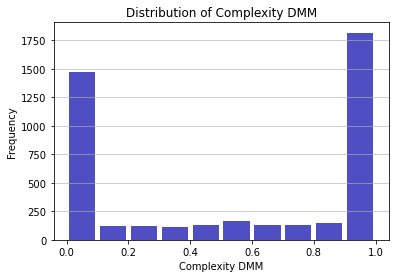

In [11]:
fig, ax = plt.subplots()
ax.hist(x=riskProfileComplexity, bins=10, color='#0504aa', alpha=0.7, rwidth=0.85)

ax.grid(axis='y', alpha=0.75)
ax.set_xlabel('Complexity DMM')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Complexity DMM')
plt.show()


We also take a look at the change frequency of the files. The histogram indicates that a small number of files is modified very frequently. This indicates that some files might potentially be problematic entities. The 20 files with the highest change frequency are also displayed.

In [12]:
"""
modifiedFiles = []

for commit in tqdm(repo.traverse_commits()):
    for file in commit.modified_files:
        modifiedFiles.append(file.filename)
"""
modifiedFiles = deserialize('data/', 'modifiedFiles')
fileChangeFrequency = Counter(modifiedFiles) 

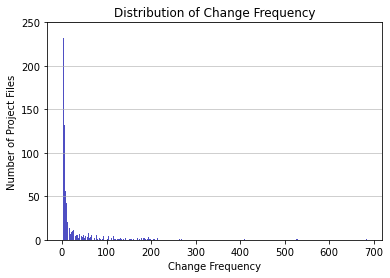

In [13]:
fig, ax = plt.subplots()

ax.hist(x=[fileChangeFrequency[key] for key in fileChangeFrequency], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
ax.set_ylim((0, 250))

ax.grid(axis='y', alpha=0.75)
ax.set_xlabel('Change Frequency')
ax.set_ylabel('Number of Project Files')
ax.set_title('Distribution of Change Frequency')
plt.show()

In [14]:
print(fileChangeFrequency.most_common(20))

[('core.go', 685), ('main.go', 662), ('dht.go', 602), ('add.go', 564), ('bitswap.go', 529), ('interface.go', 526), ('pin.go', 524), ('README.md', 517), ('package.json', 463), ('go.sum', 435), ('go.mod', 431), ('daemon.go', 420), ('routing.go', 414), ('swarm.go', 410), ('object.go', 344), ('ls.go', 319), ('init.go', 317), ('Makefile', 310), ('Godeps.json', 269), ('gateway_handler.go', 267)]


Based on these considerations, our following analysis uses **source code files** as the entities of interest.

### List of Entities in v0.10.0

In [15]:
repoV10 = Repository(path, from_tag='v0.10.0')

In [16]:
"""
entitiesV10 = set()

for commit in tqdm(repoV10.traverse_commits()):
    for file in commit.modified_files:
        entitiesV10.add(file.filename)
        
serialize('data/', 'entitiesV0.10.0', entitiesV10)
"""

entitiesV10 = list(deserialize('data/', 'entitiesV0.10.0'))

print(f'Number of entities in v0.10.0: {len(entitiesV10)}\n')

for entry in sorted(entitiesV10):
    print(entry)

Number of entities in v0.10.0: 102

CHANGELOG.md
Dockerfile
EARLY_TESTERS.md
README.md
RELEASE_ISSUE_TEMPLATE.md
Rules.mk
add.go
assets_test.go
bindata.go
bindata_version_hash.go
commands_test.go
config.md
config.yml
daemon.go
dag.go
dht_test.go
dir-index-html
discovery.go
dns.go
docker-compose.yaml
docker-image.yml
export.go
fetcher.go
files.go
fuse.go
gateway.go
gateway_test.go
get.go
go.mod
go.sum
hostname.go
hostname_test.go
id.go
import.go
ipfs-hardened.service
ipfs-logo.png
ipfs.paper.draft3.pdf
ipfs.service
large-k8s.toml
levelds.go
libp2p.go
main.go
main.yml
main_test.go
manifest.toml
medium-k8s.toml
metrics_test.go
mkreleaselog
multibase.go
patch.go
path_test.go
peering.go
peering_test.go
peerlog.go
peerlog_test.go
preload.go
preload_list
push-docker-tags.sh
put.go
readonly_unix.go
small-docker.toml
small-k8s.toml
snap.md
swarm.go
sync-release-assets.yml
t0026-id.sh
t0032-mount-sharded.sh
t0040-add-and-cat.sh
t0041-ping.sh
t0043-add-w.sh
t0044-add-symlink.sh
t0051-object.sh
t0

### Complexity Metric
As a complexity metric, we use the **McCabe's cyclomatic complexity** (CC). It is a well known metric for measuring software complexity and it measures the number of independent linear paths in the code as determinded by a control flow graph. In our opinion, this seems to be the better choice than relying on metrics such as lines of code (LOC). Why? The LOC metric depends on the language as well as the programmer. This argument is relevant since ipfs-go is an open source project with a considerable number of contributors.

In [17]:
print(f'Number of project contributors (including double counts): {len(set(contributors))}\n')

Number of project contributors (including double counts): 358



### Timeframe of the Analysis
To decide on a timeframe, we inspect the temporal history of the project regarding the number of commits per month, the number of added and deleted lines per month, and the number of changed files per month. These information are all available via the PyDriller framework.

We observe that there is a peak in the number of commits per month as well as the number of added and deleted files per month at the beginning of the project. Our hypothesis is that this pattern is due to the higher dynamic at the early stage of the project. After this initial period, the numbers level out. When it comes to the number of changed files per month, there is another peak at a later stage in the project, indicating an increased activity.

Based on these observations, our **timeframe for the analysis includes all commits between the versions v0.4.* and v0.10.0.** This choice temporally corresponds to our observations of a more steady pattern after the initial project phase. We thus focus on the state and evolution of entities in a project phase where the activity is more steady and a architectural foundation may have been laid by the project team.

In [79]:
"""
timeline = defaultdict(list)

for commit in tqdm(repo.traverse_commits()):
    timeline[str(commit.committer_date.month) + "/" + str(commit.committer_date.year)].append(commit.hash)

commitTimeline = {key : len(timeline[key]) for key in timeline}
serialize('data/', 'commitTimeline', commitTimeline)
"""

commitTimeline = deserialize('data/', 'commitTimeline')

In [80]:
"""
modifiedLines = defaultdict(list)

for commit in tqdm(repo.traverse_commits()):
    modifiedLines[str(commit.committer_date.month) + "/" + str(commit.committer_date.year)].append(commit.lines)

serialize('data/', 'modifiedLinesTimeline', modifiedLines)
"""

modifiedLinesTimeline = deserialize('data/', 'modifiedLinesTimeline')
modifiedLinesTimeline = {key : sum(modifiedLinesTimeline[key]) for key in modifiedLinesTimeline}

In [81]:
"""
modifiedFilesTimeline = defaultdict(list)

for commit in tqdm(repo.traverse_commits()):
    modifiedFilesTimeline[str(commit.committer_date.month) + "/" + str(commit.committer_date.year)].append(commit.files)

serialize('data/', 'modifiedFilesTimeline', modifiedFilesTimeline)
"""

modifiedFilesTimeline = deserialize('data/', 'modifiedFilesTimeline')
modifiedFilesTimeline = {key : sum(modifiedFilesTimeline[key]) for key in modifiedFilesTimeline}

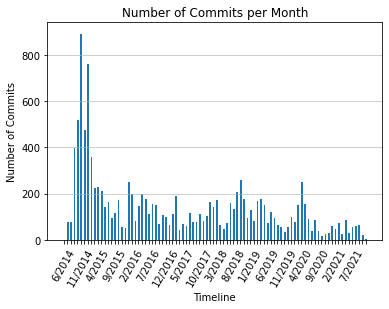

In [82]:
fig, ax = plt.subplots()

ax.bar([key for key in commitTimeline], [commitTimeline[key] for key in commitTimeline], edgecolor='white')
ax.grid(axis='y', alpha=0.75)

for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

ax.set(xlabel='Timeline', ylabel='Number of Commits', title='Number of Commits per Month')
plt.xticks(rotation=60)
plt.show()


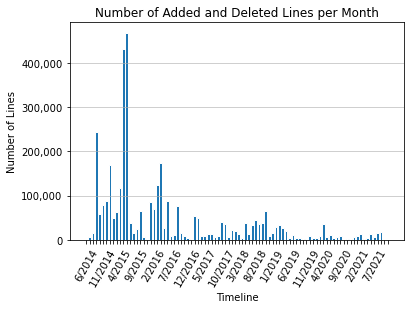

In [83]:
fig, ax = plt.subplots()

ax.bar([key for key in modifiedLinesTimeline], [modifiedLinesTimeline[key] for key in modifiedLinesTimeline], edgecolor='white')
ax.grid(axis='y', alpha=0.75)

for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

tick = ticker.StrMethodFormatter('{x:,.0f}')
ax.yaxis.set_major_formatter(tick) 
        
ax.set(xlabel='Timeline', ylabel='Number of Lines', title='Number of Added and Deleted Lines per Month')
plt.xticks(rotation=60)
plt.show()
        
    

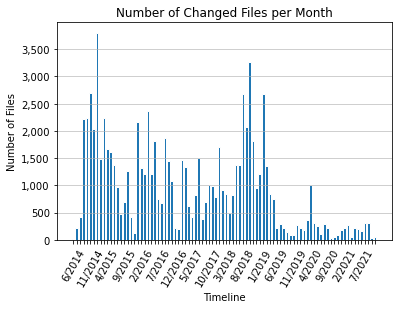

In [78]:
fig, ax = plt.subplots()

ax.bar([key for key in modifiedFilesTimeline], [modifiedFilesTimeline[key] for key in modifiedFilesTimeline], edgecolor='white')
ax.grid(axis='y', alpha=0.75)

for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

tick = ticker.StrMethodFormatter('{x:,.0f}')
ax.yaxis.set_major_formatter(tick) 
        
ax.set(xlabel='Timeline', ylabel='Number of Files', title='Number of Changed Files per Month')
plt.xticks(rotation=60)
plt.show()

### List of Hotspots
From now on, we work with a new repo, reflecting the timeframe choice we made in the last section.


In [87]:
repoAnalysis = Repository(path, from_tag='v0.4.0-rc1')